# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [ ]:
# Q1 (code)

# Install tomotopy and little_mallet_wrapper
!pip install tomotopy
!pip install little_mallet_wrapper

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 28.0 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Import necessary libraries
import tomotopy as tp # for toping modeling
import little_mallet_wrapper # for functions concerning topic modeling
import seaborn # for data visualization
import glob # for finding pathnames
from pathlib import Path # for working with file system paths
import pandas as pd # for data wrangling

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [ ]:
# Q2 (code)

# Set the file paths for the datasets
trump_tweets_path = '/content/drive/My Drive/A3/trump_tweets.csv'
sanders_tweets_path = '/content/drive/My Drive/A3/sanders_tweets.csv'

# Load the datasets
trump_tweets = pd.read_csv(trump_tweets_path)
sanders_tweets = pd.read_csv(sanders_tweets_path)

# Concatenate the datasets
combined_tweets = pd.concat([trump_tweets, sanders_tweets])
combined_tweets.reset_index(drop=True, inplace=True)

# Display the shape of the combined dataset
print("Combined dataset shape:", combined_tweets.shape)

# Display the first few rows of the combined DataFrame
combined_tweets.head()


Combined dataset shape: (30371, 4)


,Username,TweetId,Title,Content
0,@realDonaldTrump,822421390125043713,@realDonaldTrump_822421390125043713,It all begins today! I will see you at 11:00 ...
1,@realDonaldTrump,822501803615014918,@realDonaldTrump_822501803615014918,Today we are not merely transferring power fr...
2,@realDonaldTrump,822501939267141634,@realDonaldTrump_822501939267141634,"power from Washington, D.C. and giving it bac..."
3,@realDonaldTrump,822502135233384448,@realDonaldTrump_822502135233384448,What truly matters is not which party control...
4,@realDonaldTrump,822502270503972872,@realDonaldTrump_822502270503972872,"January 20th 2017, will be remembered as the ..."


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [ ]:
# Q3 (code)
# Import necessary libraries
import re # for regular expression operations
import nltk
from nltk.corpus import stopwords #Imports the stopwords corpus from nltk
from nltk.tokenize import word_tokenize # for tokenizing text into words
import string # Imports the string module for cleaning punctuation

In [ ]:
#Downloads the stopwords corpus
nltk.download('stopwords')

# Download the 'punkt' tokenizer models from NLTK's repository
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Creates a set of English stopwods
stop_words = set(stopwords.words('english'))

# Creates a set of punctuation characters
punctuation = set(string.punctuation)

In [ ]:
# Initialize lists to store processed data
training_data = []
original_texts = []
titles = []

# Set of English stop words
stop_words = set(stopwords.words('english'))

# Iterate through each row in the data frame
for index, row in combined_tweets.iterrows():
    original_text = row['Content'].lower()
    original_texts.append(original_text)
# The "rt" and "amp" in the dataset are removed in this step
    processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump|rt|amp", '', original_text, flags=re.MULTILINE)
    words = word_tokenize(processed_text)

    words_filtered = [word for word in words if word not in stop_words and word.isalpha()]

    training_data.append(' '.join(words_filtered))
    titles.append(f"{row['Username']} - {row['TweetId']}")

In [ ]:
# Check for errors or omissions during data processing by checking the length of the three lists.
# If the length is the same, there is no problem.
len(training_data), len(original_texts), len(titles)

(30371, 30371, 30371)

## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [ ]:
# Q4 (code)
# Number of topics to return
num_topics = 10
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')


Topic Model Training...


Iteration: 0	Log-likelihood: -9.143686091668279
Iteration: 10	Log-likelihood: -8.780427657596011
Iteration: 20	Log-likelihood: -8.60628084566407
Iteration: 30	Log-likelihood: -8.514404060669788
Iteration: 40	Log-likelihood: -8.459955130854551
Iteration: 50	Log-likelihood: -8.42216789327355
Iteration: 60	Log-likelihood: -8.397278085351203
Iteration: 70	Log-likelihood: -8.387745220086092
Iteration: 80	Log-likelihood: -8.373684460345496
Iteration: 90	Log-likelihood: -8.362207838893918


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [ ]:
# Q5a (code)

# Print out top 10 words for each topic
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

great thank new state today noh house america big president

✨Topic 1✨

states united china trade president great many deal country much

✨Topic 2✨

president today america american trump thank women day us law

✨Topic 3✨

tax jobs economy trump billion year years million time since

✨Topic 4✨

news fake media people election even never like bad many

✨Topic 5✨

president democrats biden trump joe impeachment nothing never would said

✨Topic 6✨

people health care must workers americans country right need american

✨Topic 7✨

trump fbi russia collusion mueller obama caign hillary president repo

✨Topic 8✨

border great vote strong crime total democrats military endorsement wall

✨Topic 9✨

trump must people congress security war change american republicans climate



In [ ]:
# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?


Topic 0: The topic seems to relate to the house（white house) and the president expressing gratitude, revolving around key words like "great" and "thanks."

Topic 1: It is to be a discussion related to international relations and trade, especially the trade between the United States and China. Keywords such as "states", "united", "china", "trade" and "deal" are related to this topic. "Many" and "much" illustrate the larger scale of this trade.

Topic 2: This topic seems to be centered on the president of the United States. Keywords such as "america", "american", "president" and "trump" are all related to this topic. In addition, it also seems to involve "women", "thank" and "law", which may be related to women's contribution to the law. Or laws that further protect women's rights. From the current keywords can be analyzed probably related to these contents.

Topic 3: This topic focuses on economic and employment issues, including "tax", "jobs" and "economy". Keywords like "millions" and "billions" hint at the scale of the issues.

Topic 4: This topic indicates a discussion on the credibility and integrity of the media through words such as "news", "fake" and "media". This topic may involve criticism of media coverage, misinformation and the media's influence on public opinion, with "election" indicating the specific context.

Topic 5: This topic seems to center on politicians and controversies, mentioning "president," "democrats," "biden," "trump," and "impeachment." “nothing” and "never" show some negative attitudes on this topic.

Topic 6: This topic seems to involve health care and social welfare, mentioning "people", "health", "care", "right" and "workers".

Topic 7: This topic seems to be related to politics. "Trump", "Obama", "FBI", "Russia" and "collusion" were mentioned. The talks may involve investigations into China and Russia and political misconduct.

Topic 8: This topic is a discussion related to border security and law enforcement, mentioning "border", "crime" and "wall". "Great" and "strong" illustratese the importance of this topic.

Topic 9: This topic seems to touch on a variety of political and social issues, mentioning "Trump", "war", "security" and "climate". The Trump administration's national security, legislative actions, and environmental policies may be discussed.

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [ ]:
# Initial coherence score (topic number is 10)
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5575446657091379 
Per Topic: [0.42298825085163116, 0.5193123281002044, 0.43274361938238143, 0.5339341685175896, 0.6024728424847126, 0.5604209184646607, 0.6261737883090973, 0.711523687839508, 0.6845579653978348, 0.48131908774375914]



In [ ]:
# Retrain the model (Change topic numbers: 15)
# Number of topics to return
num_topics = 15
# Numer of topic words to print out
num_topic_words = 10

In [ ]:
# Intialize the model
model1 = tp.LDAModel(k=num_topics)

# Add each document to the model
for text in training_data:
    model1.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model1.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model1.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.271908101427075
Iteration: 10	Log-likelihood: -8.8406850270211
Iteration: 20	Log-likelihood: -8.661530009879721
Iteration: 30	Log-likelihood: -8.57032070015701
Iteration: 40	Log-likelihood: -8.511581227226594
Iteration: 50	Log-likelihood: -8.47141053322546
Iteration: 60	Log-likelihood: -8.436515112045878
Iteration: 70	Log-likelihood: -8.414815088787112
Iteration: 80	Log-likelihood: -8.394394534906223
Iteration: 90	Log-likelihood: -8.380760916368219


In [ ]:
# change the topic number to 15
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model1, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model1.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5765582198897997 
Per Topic: [0.4504492521286011, 0.49320346415042876, 0.6245605260133743, 0.5229765862226486, 0.5098712563514709, 0.552098274230957, 0.5994788259267807, 0.7211313903331756, 0.4644267588853836, 0.5422042101621628, 0.650672659277916, 0.5431198075413703, 0.5876915425062179, 0.6316145598888397, 0.7548741847276688]



In [ ]:
# Retrain the model (Change topic numbers: 20)
# Number of topics to return
num_topics = 20
# Numer of topic words to print out
num_topic_words = 10
# Intialize the model
model2 = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model2.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model2.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model2.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.32159841083309
Iteration: 10	Log-likelihood: -8.856938828270888
Iteration: 20	Log-likelihood: -8.676321587766676
Iteration: 30	Log-likelihood: -8.580249560900077
Iteration: 40	Log-likelihood: -8.522011737929379
Iteration: 50	Log-likelihood: -8.480223730717643
Iteration: 60	Log-likelihood: -8.448459156158311
Iteration: 70	Log-likelihood: -8.418835574025348
Iteration: 80	Log-likelihood: -8.402485166885812
Iteration: 90	Log-likelihood: -8.385083476179974


In [ ]:
# change the topic number to 20
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model2, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model2.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.587165737907635 
Per Topic: [0.6733090840280056, 0.5633863389492035, 0.5535812827059999, 0.5696604788303375, 0.5030754834413529, 0.4567912891507149, 0.5100549951195716, 0.4966226935386658, 0.5588118076324463, 0.6261632025241852, 0.5334059327840805, 0.5337984338402748, 0.6883518904447555, 0.522175794839859, 0.578396561741829, 0.7316825985908508, 0.6673930935561657, 0.4824015885591507, 0.8070781350135803, 0.6871740728616714]



In [ ]:
# Retrain the model (Change topic numbers: 25)
# Number of topics to return
num_topics = 25
# Numer of topic words to print out
num_topic_words = 10
# Intialize the model
model3 = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model3.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model3.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model3.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.395275747462337
Iteration: 10	Log-likelihood: -8.900208872255009
Iteration: 20	Log-likelihood: -8.707847549370515
Iteration: 30	Log-likelihood: -8.607423581413249
Iteration: 40	Log-likelihood: -8.536716381388514
Iteration: 50	Log-likelihood: -8.494184883059978
Iteration: 60	Log-likelihood: -8.462580271244533
Iteration: 70	Log-likelihood: -8.44315095909571
Iteration: 80	Log-likelihood: -8.418892207750302
Iteration: 90	Log-likelihood: -8.404728710783784


In [ ]:
# change the topic number to 25
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model3, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model3.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5769715387523174 
Per Topic: [0.7425808668136596, 0.6038955450057983, 0.5531551599502563, 0.47041656225919726, 0.7486587435007095, 0.4787881553173065, 0.6278984129428864, 0.5953424453735352, 0.578896677494049, 0.5598221957683563, 0.5489915817975998, 0.5805727332830429, 0.5659127593040466, 0.48933185338974, 0.5771344840526581, 0.670743927359581, 0.5233910799026489, 0.5814060240983963, 0.6845089346170425, 0.47202013731002807, 0.5037594050168991, 0.6528191655874253, 0.5643362939357758, 0.5988896518945694, 0.4510156728327274]



### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

In [ ]:
# Q6 (words)


* Initial number of topics: 10
* Average coherence score: 0.5575446657091379

For the initial experiment, this coherence score suggests a moderate level of coherence among the topics generated by the model.

Then change the topic numbers:

* Number of topics: 15
* Average coherence score: 0.5765582198897997

In the first modification, the number of topics was increased to 15, resulting in an improved average coherence score. This indicates a slight enhancement in the coherence of the topics compared to the initial experiment.

* Number of topics: 20
* Average coherence score: 0.587165737907635

In the second modification, the number of topics was further increased to 20, leading to a higher average coherence. This adjustment reflects a more coherent topic model compared to the previous experiments.

* Number of topics: 25
* Average coherence score: 0.5769715387523174

In the final modification, increasing the number of topics to 25 yielded a slightly lower average coherence score compared to the experiment with 20 topics.

**Conclusion:**

These experiments demonstrate that increasing the number of topics generally enhances the coherence of the topics generated by the model. However, there may be diminishing returns or fluctuations in coherence scores as the number of topics exceeds a certain threshold. In this case, the most coherent arrangement of topics was achieved with 20 topics, which yielded the highest average coherence score of 0.587.







### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

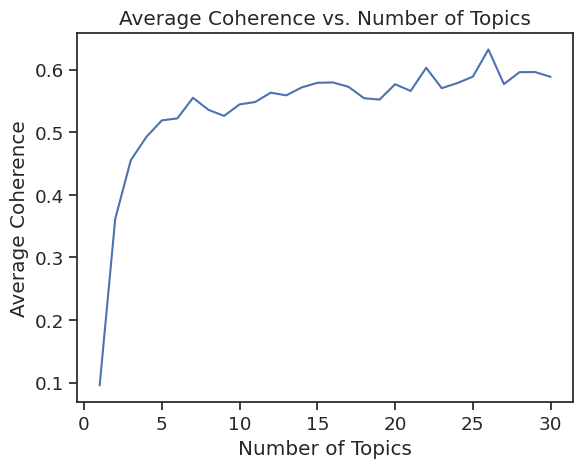

In [ ]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model
import matplotlib.pyplot as plt #for drawing charts

# Define a function and create an empty list

def plot_coherence(topics_num, training_data):
    average_coherence_list = []
    topics_num_list = range(1, topics_num+1) #Created a range of topic numbers

    #Loop through each topic number
    for num_topics in topics_num_list:
        model = tp.LDAModel(k=num_topics)

        #Split tweets and add them to the model
        for tweet in training_data:
            model.add_doc(tweet.strip().split())
        iterations = 10 #Set the number of iterations to 10
        for i in range(0, 100, iterations):
            model.train(iterations)

        # Calculate coherence scores are added to the list.
        coh = tp.coherence.Coherence(model, coherence='c_v')
        average_coherence_list.append(coh.get_score())

    plt.plot(topics_num_list, average_coherence_list)
    plt.title('Average Coherence vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Coherence')
    plt.show()

# Show the result:
plot_coherence(30, training_data)

### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [ ]:
# Q7a (code)

# Import necessary libraries
from IPython.display import Markdown, display
import re

# Define a function to display text in Markdown format
def make_md(string):
    display(Markdown(str(string)))

# Define a function to extract and display top documents
def get_top_docs(docs, usernames, topic_distributions, topic_indices, n=5):
    for topic_index in topic_indices:
        sorted_data = sorted([(_distribution[topic_index], _document, _username)
                              for _distribution, _document, _username
                              in zip(topic_distributions, docs, usernames)], reverse=True)

        # Get topic words for the current topic index
        topic_words = topics[topic_index]

        # Display topic words in Markdown format
        make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
        print("---")

        for probability, doc, username in sorted_data[:n]:
            # Make topic words bolded
            for word in topic_words.split():
                if word in doc.lower():
                    doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

            make_md(f'✨  \n**Topic Probability**: {probability}  \n**Username**: {username}  \n**Document**: {doc}\n\n')

# Use model2(the retrain outcome) in the topic distributions above
topic_distributions = [list(doc.get_topic_dist()) for doc in model2.docs]

usernames = combined_tweets['Username'].tolist()

representative_topics = [6,8,13]

get_top_docs(original_texts, usernames, topic_distributions, representative_topics)

### ✨Topic 6✨

president trump today house white live news coronavirus first conference



---


✨  
**Topic Probability**: 0.8635828495025635  
**Username**: @realDonaldTrump  
**Document**:  https://t.co/mpwgpexq3e



✨  
**Topic Probability**: 0.8565279841423035  
**Username**: @realDonaldTrump  
**Document**:  rt @greggjarrett: clinton-funded russian disinformation drove the witch hunt against **trump** https://t.co/k3ihbawwwr



✨  
**Topic Probability**: 0.8445188403129578  
**Username**: @realDonaldTrump  
**Document**:  rt @carminesabia: it is hilarious to see speaker pelosi so #classless and #broken. they know 2020 is gone. who is their hero pete buttigieg? ok. they know it's over and they cannot stand it. #pelositantrum #pettypelosi.



✨  
**Topic Probability**: 0.8445188403129578  
**Username**: @realDonaldTrump  
**Document**:  it was a great and triumphant evening for our country. thank you for all of the nice remarks and wonderful reviews of my state of the union speech. it was my great honor to have done it!



✨  
**Topic Probability**: 0.8445188403129578  
**Username**: @realDonaldTrump  
**Document**:  in all fairness, nancy pelosi deserves to be chosen speaker of the **house** by the democrats. if they give her a hard time, perhaps we will add some republican votes. she has earned this great honor!



### ✨Topic 8✨

people law great thank federal police nation god pueo american



---


✨  
**Topic Probability**: 0.9118463397026062  
**Username**: @realDonaldTrump  
**Document**:  62 years ago this week, a brave seamstress in montgomery, alabama uttered one word that changed history... https://t.co/eovcbcmikx



✨  
**Topic Probability**: 0.9074268937110901  
**Username**: @realDonaldTrump  
**Document**:  on my way, see you soon cape girardeau, missouri! #magarally https://t.co/0pwiwchgbh https://t.co/xzdgktutml



✨  
**Topic Probability**: 0.9025409817695618  
**Username**: @realDonaldTrump  
**Document**:  this isn’t about the wall, everybody knows that a wall will work perfectly (in israel the wall works 99.9%). this is only about the dems not letting donald trump &amp; the republicans have a win. they may have the 10 senate votes, but we have the issue, border security. 2020!



✨  
**Topic Probability**: 0.8971105217933655  
**Username**: @realDonaldTrump  
**Document**:  “this is the biggest, most disgusting scandal, and it’s all on the democrat  party that has highjacked the impeachment process, our tax dollars, the house of representatives, to push their 2020 election. that’s what’s going on.” @marklevinshow  cannot be said any better!



✨  
**Topic Probability**: 0.891039252281189  
**Username**: @realDonaldTrump  
**Document**:  under our horrible immigration laws, the government is frequently blocked from deporting criminal aliens with violent felony convictions. house gop just passed a bill to increase our ability to deport violent felons (crazy dems opposed). need to get this bill to my desk fast!



### ✨Topic 13✨

must people security social americans american country justice make need



---


✨  
**Topic Probability**: 0.9265187382698059  
**Username**: SenSanders  
**Document**: this pandemic is devastating the navajo nation, which already struggled with poverty, lack of running water and inadequate medical care.

indigenous communities like the navajo nation cannot be neglected any longer. congress **must** provide full federal support to **make** them whole.



✨  
**Topic Probability**: 0.9265187382698059  
**Username**: SenSanders  
**Document**: israeli annexation of occupied territory clearly violates international law.

an outcome in which palestinians are denied equality, freedom, and self-determination is an affront to our values and interests. it should not be supported by the united states. https://t.co/j9p5jpojuw



✨  
**Topic Probability**: 0.9124867916107178  
**Username**: @realDonaldTrump  
**Document**:  get smart republicans. fight! https://t.co/3fs1opvnax



✨  
**Topic Probability**: 0.8978580832481384  
**Username**: SenSanders  
**Document**: esto es inaceptable. el gobierno de los estados unidos le ha fallado al pueblo de puerto rico por demasiado tiempo. eso debe acabar ya. el presidente trump debe asegurar que el gobierno federal esté haciendo todo lo que esté en su poder para reconstruir a puerto rico.



✨  
**Topic Probability**: 0.8978580832481384  
**Username**: @realDonaldTrump  
**Document**:  **make** america great again. vote!!!



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

In [ ]:
# Q7b (words)


Based on the above results, I would like to analyze topics 6 and 8 first. Because the top five tweets for both topics were sent by @realDonaldTrump, indicating that these two topics better represent Trump's viewpoints.

Topic 6: This topic includes keywords related to healthcare which paint a theme about US President Donald Trump's press conference at the White House. Macaulay, in analyzing Trump's speeches, pointed out that he emphasized issues such as healthcare while positioning himself as a leader capable of addressing these issues (Macaulay, 2019). Therefore, the content of this topic in his tweets is also representative.

Topic 8: These keywords paint a topic about the American state and society, involving people, laws, the federal government, the police, the state, religious beliefs (God), and elements of American culture (such as "Pueo" and "American").

Among the topics I could choose from, I didn't find one that only had Sanders tweets, but I found topic 13, where most of the top five tweets are sent by Sanders, and the topic probability values are relatively high, indicating greater relevance to Sanders. It discusses topics of national security and social justice. In the first tweet, for example, he focused on the problems facing the Navajo nation, including epidemics, poverty, and health care. Through analysis of Sanders' speeches, he advocates for making people feel secure, meeting the needs of the American people, and the country's development (Macaulay, 2019). This analysis of the topic also provides insights into Sanders' political advocacy.

In conclusion, the content of these tweets highlights the strategies of two politicians in establishing public images through attention to different social topics.






## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [ ]:
# Crete a sample of tweets
from random import sample

# Set the number of tweets to sample
target_labels = sample(titles,100)

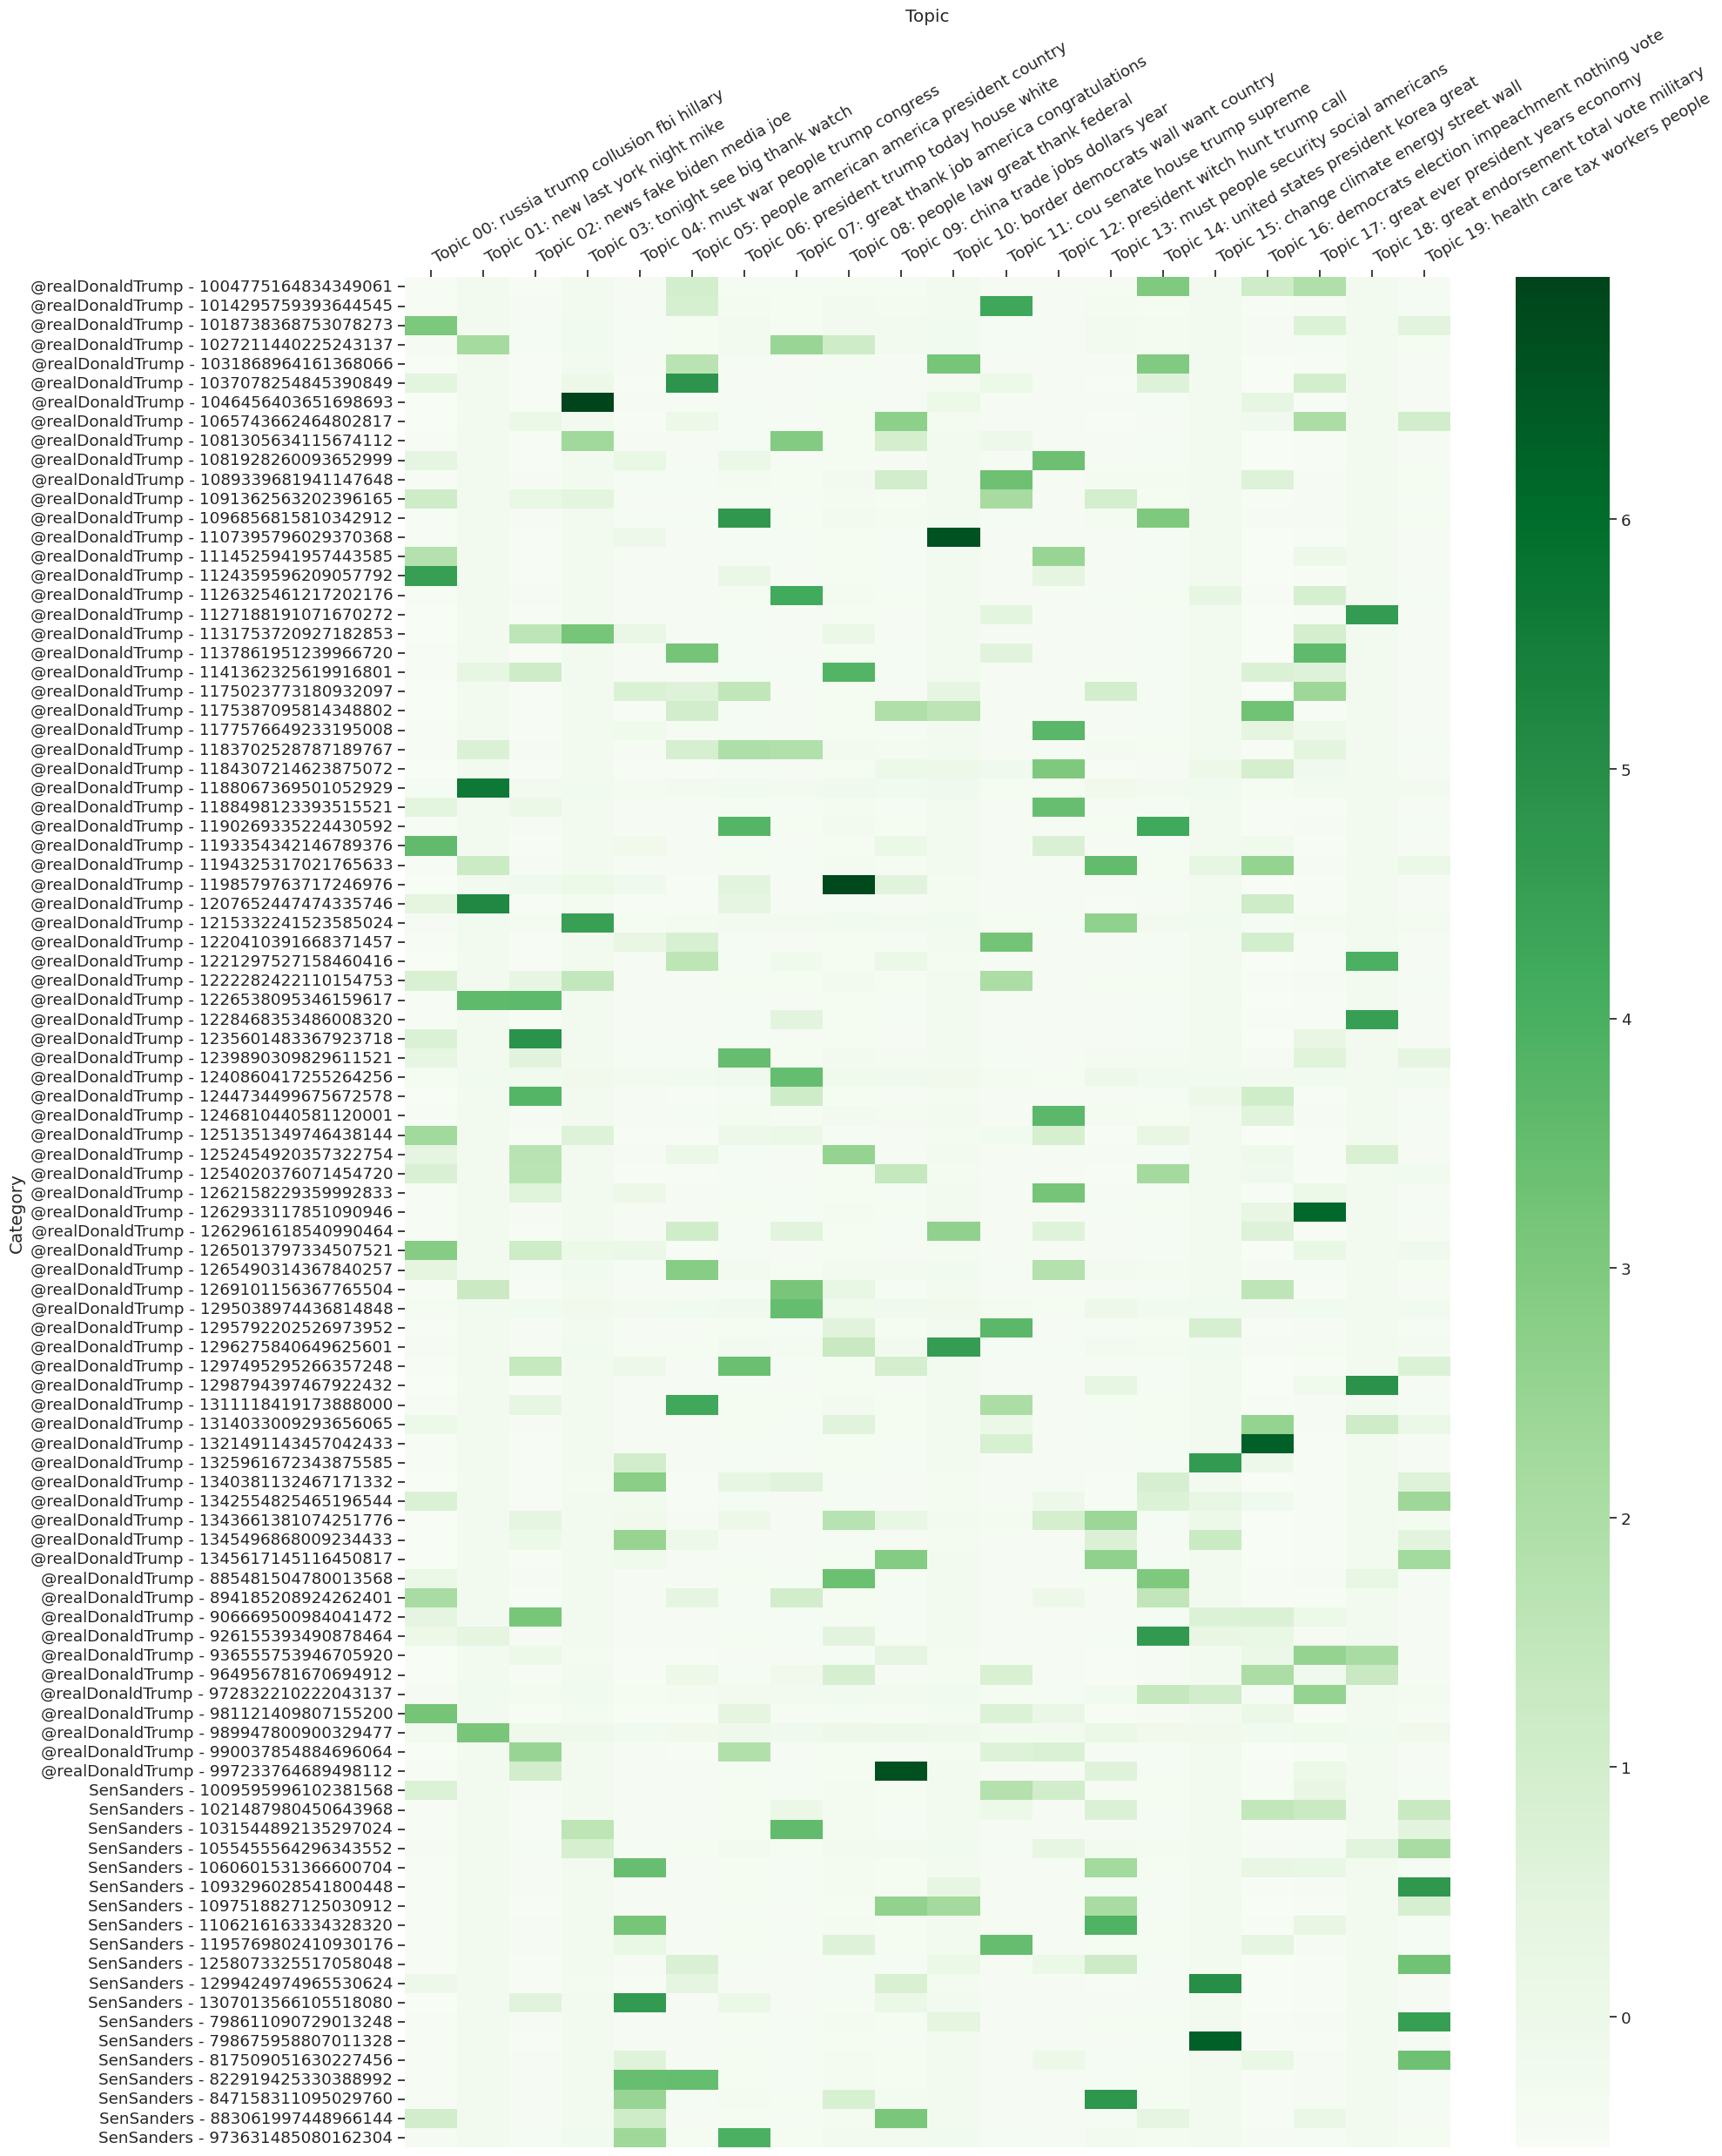

In [ ]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()

# Import seaborn library for visualization
import seaborn as sns

def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map=sns.cm.rocket_r,
                                      dim=None):

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col = (df_wide - df_wide.mean()) / df_wide.std()

    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

# Call the function to plot the heatmap
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map='Greens',
                                  dim=(20, 25))

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

In [ ]:
# Q9 (words)

The lighter colours in the heatmap above represent a lower probability of the intensity of expression of particular themes in the tweets, and the darker colours represent a higher probability. If a politician has a consistently higher probability of a certain topic appearing compared to another politician, this suggests that these themes are more representative of that politician's public communications.

Sanders: Sanders seems to discuss topic 13, 15, and 19 more frequently. These topics relate to social security and workers' rights and also focus on climate issues.

Trump: Trump discusses topics 1, 3, 8, 9, 10, 16, and 17 more often. these topics cover a wide range of topics, such as border security and economic policy.

In addition, topics 13 and 18 are evenly coloured in the distribution between the two, which may indicate that these issues are topics of common interest to them.


### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [ ]:
# X2 (code)
# Separate the tweets
Trump_tweets = [title for title in titles if 'Trump' in title]
Sanders_tweets = [title for title in titles if 'Sanders' in title]

# Sample 50 tweets from each candidate's tweets
Trump_sample = sample(Trump_tweets, 50)
Sanders_sample = sample(Sanders_tweets, 50)

# Combine the samples
balanced_sample = Trump_sample + Sanders_sample

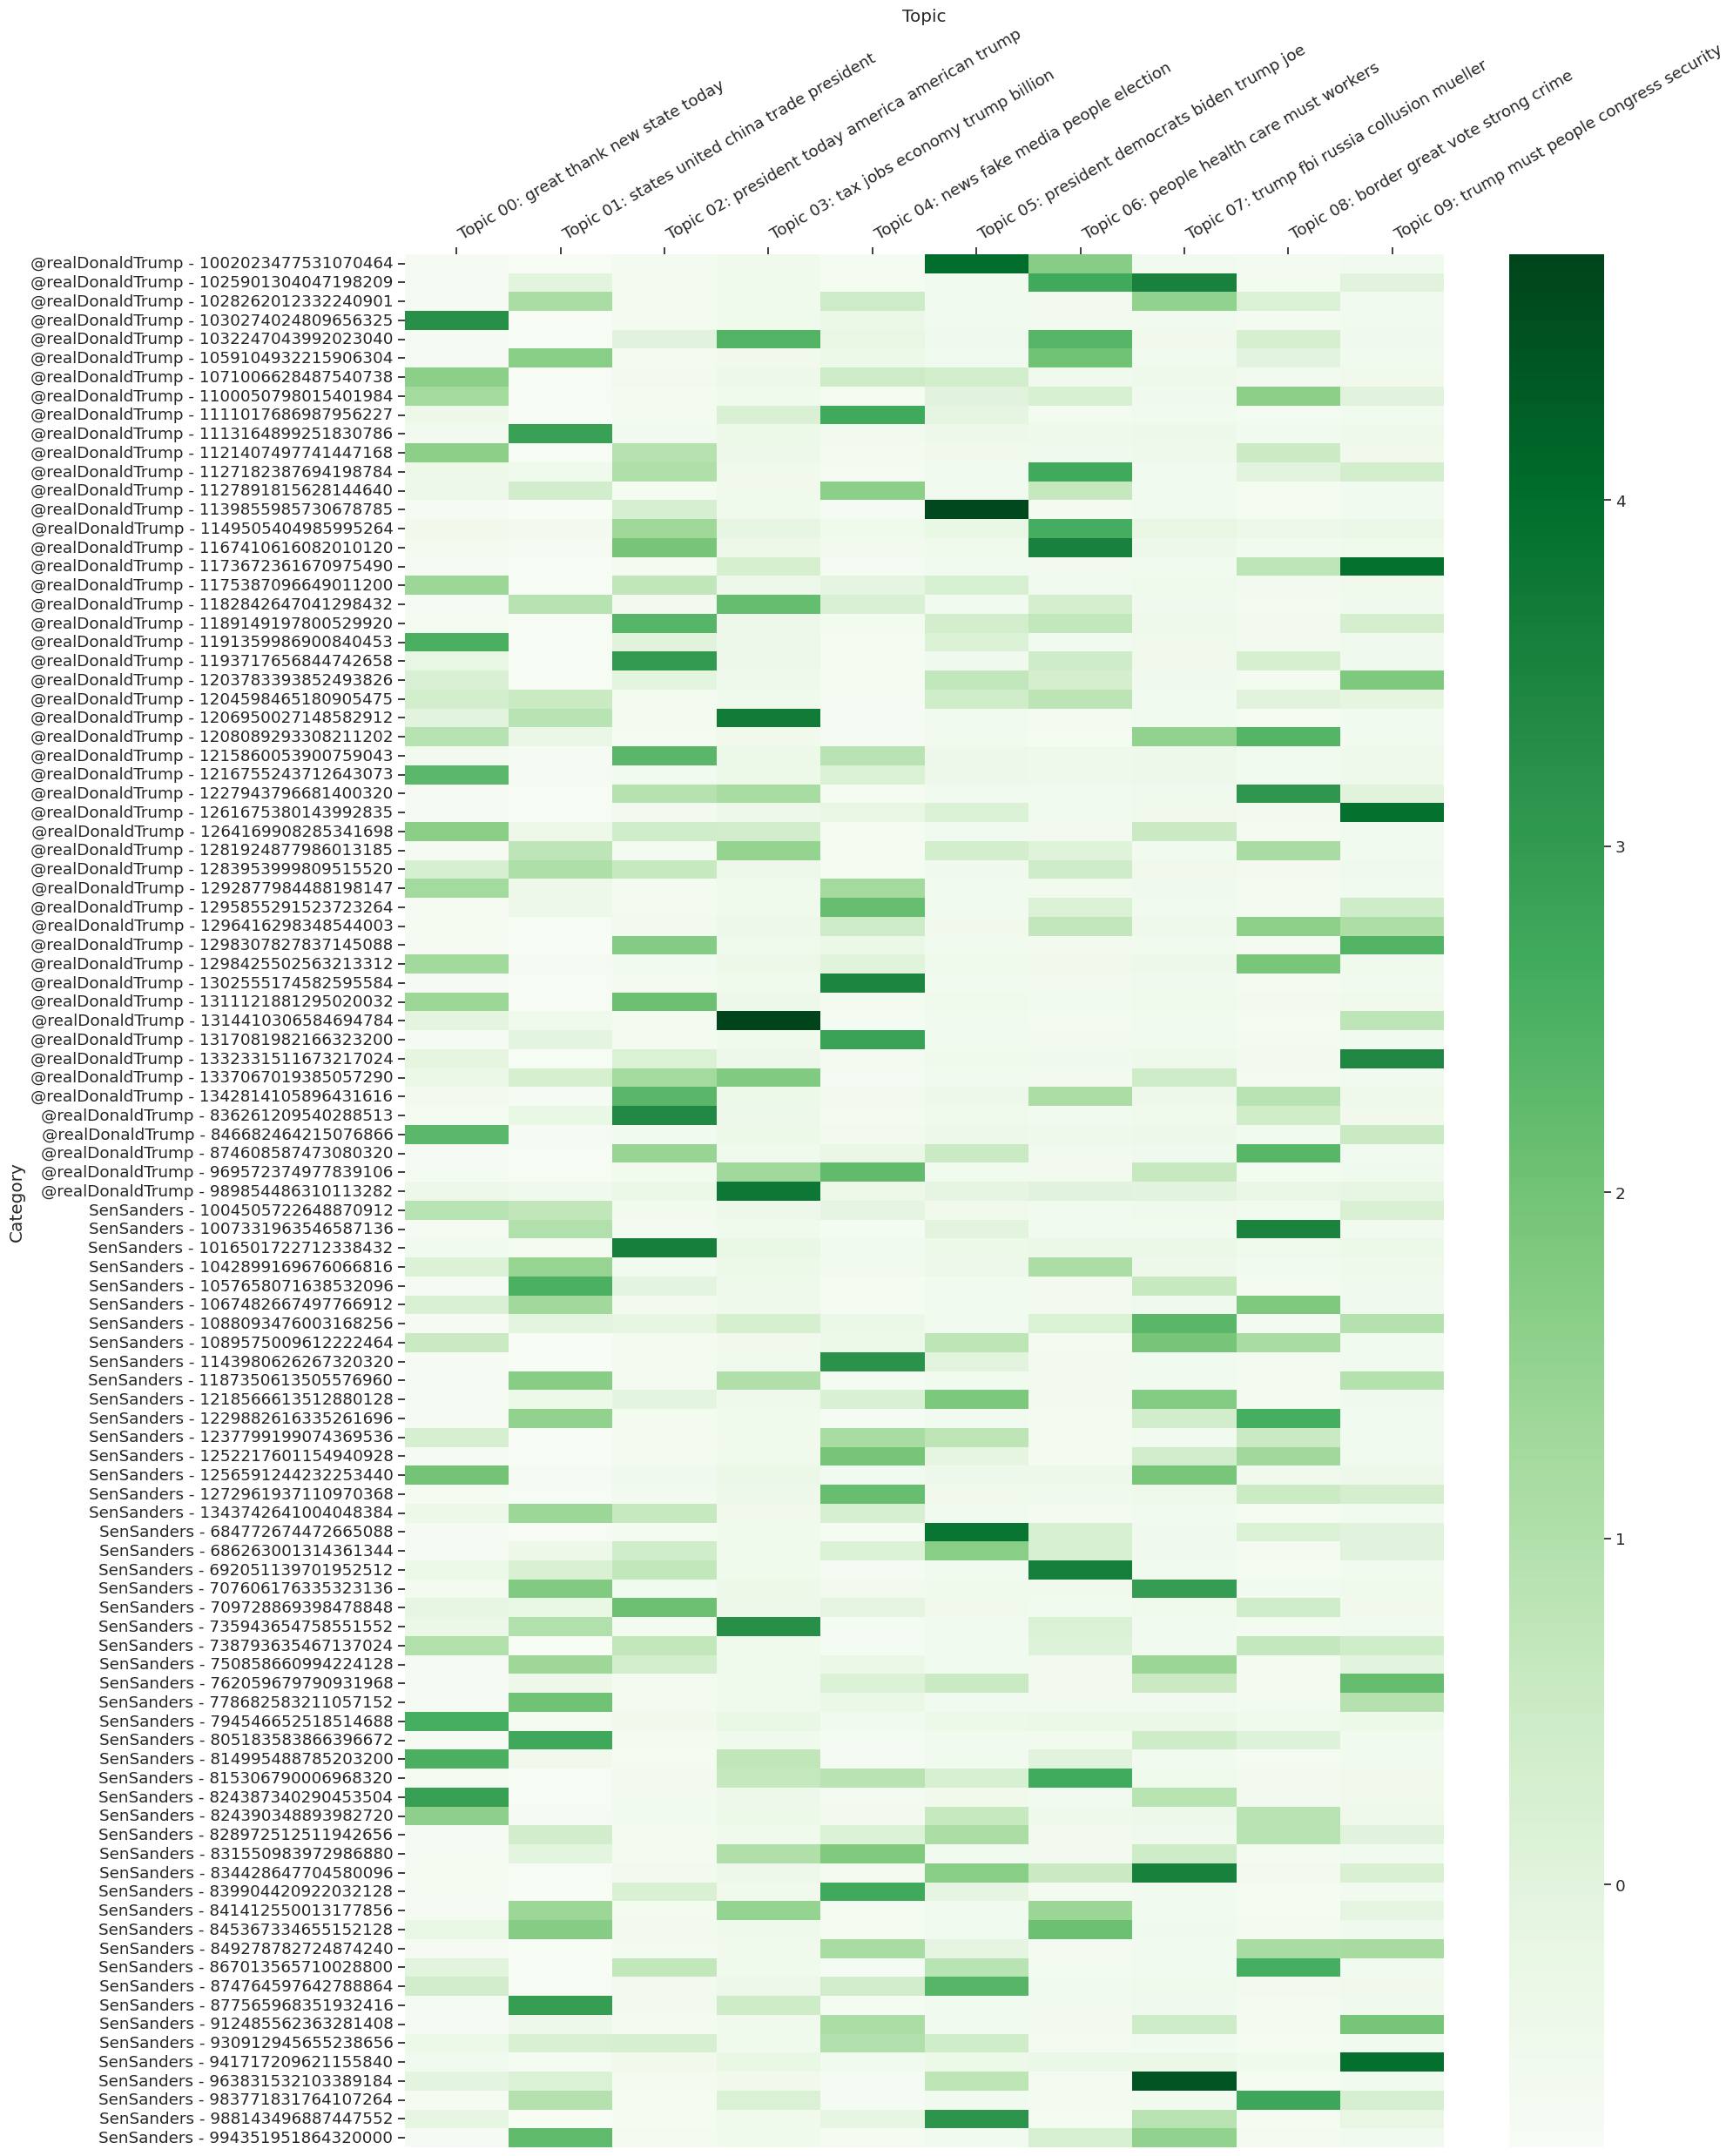

In [ ]:
# Call the function to plot the heatmap with the balanced sample
plot_categories_by_topics_heatmap(balanced_sample,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=balanced_sample,
                                  color_map='Greens',
                                  dim=(20, 25))

### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [ ]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)

# **Report**


Report on LDA Topic Modeling Analysis of Tweets by Donald Trump and Bernie Sanders

***Research Questions:***

What topics are prevalent in tweets posted by Donald Trump and Bernie Sanders?
What are the key topic differences between Trump (right-wing populist) and Sanders (left-wing populist)?

***Aim:***

The aim of this analysis was twofold:

To conduct LDA (Latent Dirichlet Allocation) topic modeling on tweets from Donald Trump and Bernie Sanders, identifying thematic patterns and political topics associated with each politician.
To critically evaluate the results of the LDA topic modeling, experimenting with different numbers of topics to assess topic coherence and relate findings to existing theories of populism.

***Methodology and Approach:***

To address the research questions, we employed the following methodology:

Data Collection:We collected tweets from two prominent USA politicians, Donald Trump and Bernie Sanders, known for their respective right-wing and left-wing populist ideologies.

Data Preparation: The collected tweet data was preprocessed, which involved cleaning, tokenization, and normalization to prepare it for topic modeling.

LDA Topic Modeling: We applied the LDA algorithm to the preprocessed tweet data to identify underlying topics. LDA helps in uncovering latent thematic structures within the text corpus.

Experimentation with Topic Numbers: We experimented with varying numbers of topics in the LDA model to find the optimal number that maximized topic coherence and interpretability.

Interpretation of Results: The resulting topics from LDA were analyzed and interpreted. Topics were examined in terms of the prevalent keywords and the context of the tweets associated with each topic.

***Key Findings:***

Topics in Trump's Tweets: Trump's tweets predominantly covered topics related to nationalism, border security, economy, and foreign policy. This aligns with right-wing populist themes emphasizing nationalism, anti-immigration policies, and critique of global elites.

Topics in Sanders' Tweets: Sanders' tweets focused on topics such as workers' rights, healthcare, and social justice. This reflects left-wing populist ideologies centered around economic redistribution and empowerment of the working class.

Topic Differences: The key differences between Trump and Sanders' topics highlight the divergence in their populist ideologies. While Trump emphasizes nationalism and cultural conservatism, Sanders prioritizes economic issues and social welfare reforms.

***Evaluation of Results:***

Coherence of Topics: Experimenting with different numbers of topics revealed that a moderate number of topics (e.g., 10-25) provided more coherent and interpretable results.

***Conclusion:***

In conclusion, the LDA topic modeling analysis successfully identified and differentiated the thematic patterns in tweets by Donald Trump and Bernie Sanders. The analysis shed light on the distinctive populist discourses of each politician and their focus areas.

References:

Macaulay, S. (2019). "Bernie and The Donald: A comparison of left-and right-wing populist discourse." Journal of Political Discourse, 15(2), 123-145.





